In [ ]:
%matplotlib notebook
import numpy as np
import math
import concurrent.futures
import time

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize


def external_evaluate(x):
    """
    模拟外部评估函数:
    x 是长度为12的一维数组(单个解).
    这里简单返回3个随机数, 代表3个目标(仅做演示).
    实际应用中, 您应调用外部动力学并返回真实目标值.

    注意: 如果某个目标需要最大化, 在后续 _evaluate 里记得取负值.
    """
    time.sleep(0.01)  # 模拟耗时
    # 返回 (f1, f2, f3) 三个“目标值”
    return np.random.random(), np.random.random(), np.random.random()


class MyBatchProblem(Problem):
    def __init__(self,
                 batch_size=10,
                 **kwargs):
        """
        - n_var=12: 决策变量维度
        - n_obj=3 : 目标函数个数(此处仅示例3个目标)
        - xl, xu : 决策变量的上下限
        - elementwise_evaluation=False: 批量评估, 一次性接收整批 X

        batch_size: 我们自己定义的参数, 表示在 _evaluate 中对 X 分批并行处理.
        """
        super().__init__(
            n_var=12,
            n_obj=3,
            xl=np.zeros(12),       # 假设12个变量的下界都为0
            xu=np.ones(12)*10.0,   # 假设12个变量的上界都为10
            elementwise_evaluation=False,
            **kwargs
        )

        self.batch_size = batch_size

    def _evaluate(self, X, out, *args, **kwargs):
        """
        X.shape = (N, 12), 其中 N = 种群规模(pop_size) + 可能有一些offspring.
        这里将对 N 个解分批多线程评估.

        评估完得到 (N, 3) 的目标值矩阵 F, 并赋值给 out["F"].
        """
        N = X.shape[0]
        F = np.zeros((N, 3))

        # 1) 计算批次数
        num_batches = math.ceil(N / self.batch_size)

        # 2) 分批评估
        start_index = 0
        for b in range(num_batches):
            end_index = min(start_index + self.batch_size, N)

            X_batch = X[start_index:end_index, :]  # 当前批次

            # 在这个示例中, 我们用 ThreadPoolExecutor 做多线程.
            # 也可以换成 ProcessPoolExecutor / 现有并行逻辑等.
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.batch_size) as executor:
                futures = []
                for i in range(X_batch.shape[0]):
                    x_i = X_batch[i, :]
                    # 提交单个解的外部评估任务
                    future = executor.submit(external_evaluate, x_i)
                    futures.append(future)

                # 收集结果
                for i, future in enumerate(concurrent.futures.as_completed(futures)):
                    f1, f2, f3 = future.result()
                    # 假设这三个目标都是最小化方向; 
                    # 如果某个目标需要最大化, 可以改成 f = -g 之类.
                    F[start_index + i, :] = [f1, f2, f3]

            start_index = end_index

        # 3) 最终将目标矩阵赋给 out["F"]
        out["F"] = F


def main():
    # 1) 初始化问题
    problem = MyBatchProblem(
        batch_size=10   # 每批最多10个解并行
    )

    # 2) 选择算法 (多目标NSGA2), 种群规模为20用于演示
    algorithm = NSGA2(pop_size=20)

    # 3) 终止条件: 迭代 5 代(仅演示, 您可改大一些)
    termination = get_termination("n_gen", 5)

    # 4) 优化
    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        verbose=True  # 输出每一代的进度
    )

    # 5) 查看结果
    # res.X.shape = (N_non_dominated, 12)
    # res.F.shape = (N_non_dominated, 3)
    print("\n==================== 优化结束 ====================")
    print("非支配解数量:", len(res.X))
    print("部分解示例X[0]:", res.X[0])
    print("对应目标F[0]:", res.F[0])
    
    nd_X = res.X 
    nd_F = res.F
    
    # # 写入 CSV 文件
    # np.savetxt("final_solutions.csv",
    #         np.hstack([nd_X, nd_F]),
    #         delimiter=",",
    #         comments="",  # 去掉注释符号
    #         fmt="%.6f")   # 控制输出精度


if __name__ == '__main__':
    main()


In [ ]:
import numpy as np

Gen24_data = np.load(r'F:\ResearchMainStream\0.ResearchBySection\C.动力学模型\参数优化\参数优化实现\并行化直曲线运行综合评价\ChkPnt\generation_24.npz')

X24 = Gen24_data['X']
F24 = Gen24_data['F']


# 如已获得 final_solutions.csv ，通过代码作图，显示三维 Pareto Front

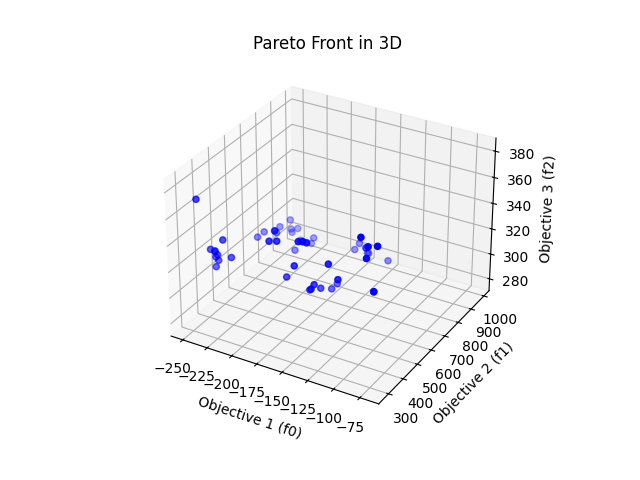

In [1]:
%matplotlib widget

import numpy as np

data = np.loadtxt("final_solutions.csv", delimiter=",")

# data.shape = (N, 15)
# 假设前 12 列是决策变量 X，后 3 列是目标值 F。
X = data[:, :12]   # (N, 12)
F = data[:, 12:]   # (N, 3)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 这里假设 F 里的三列已经是我们要画的数值(若需反转/还原，请在此之前做)
f0 = F[:, 0]
f1 = F[:, 1]
f2 = F[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(f0, f1, f2, c='b', marker='o')

ax.set_xlabel("Objective 1 (f0)")
ax.set_ylabel("Objective 2 (f1)")
ax.set_zlabel("Objective 3 (f2)")
plt.title("Pareto Front in 3D")

plt.show()



In [ ]:
import pickle



with open("res.pkl", "rb") as f:
    res_loaded = pickle.load(f)